# 28-8. 프로젝트 : 개구리는 안돼요(CIFAR-10)

In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

## Step 1. data 구성

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

# from PIL import Image

# # Fashion MNIST padding to 32 X 32
# train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
# test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
# train_data_32[:, 2:30, 2:30] = train_data
# test_data_32[:, 2:30, 2:30] = test_data

# # 1channel data reshape
# train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
# test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')



print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

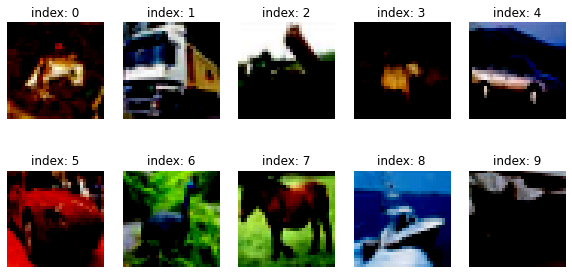

In [4]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


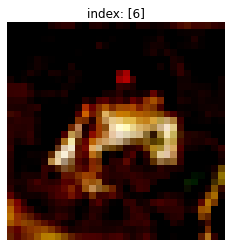

In [5]:
#개구리 label 확인

plt.imshow(train_data[0], cmap='gray')
plt.title(f'index: {train_labels[0]}')
plt.axis('off')
plt.show()

In [6]:
print(train_labels)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


index가 random하게 배치되어있는 것을 확인할 수 있다. 개구리의 index는 6이다.

In [7]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # Frog:6
            new_t_labels.append([0])  # Frog를 이상치로 처리하여 label을 0으로 지정
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치 label을 1로 지정
             
    return np.array(new_t_labels)

In [8]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [9]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [10]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [11]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [12]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [13]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

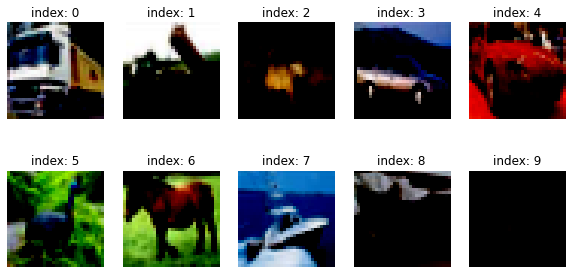

In [14]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(normal_data[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

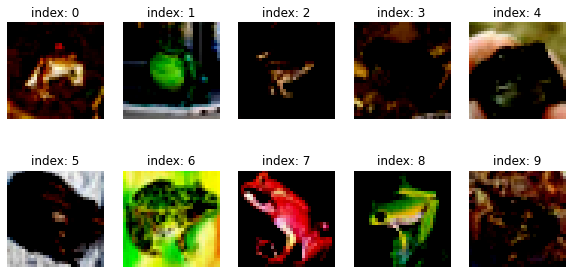

In [15]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(anomaly_data[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

개구리만 골라진 것을 확인했다.

In [16]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
for data, label in train_dataset.take(1):
    print(data)
    print(label)

tf.Tensor(
[[[[-0.30980392 -0.4745098  -0.70196078]
   [-0.30980392 -0.4745098  -0.70196078]
   [-0.30980392 -0.4745098  -0.70196078]
   ...
   [-0.2627451  -0.37254902 -0.55294118]
   [-0.27843137 -0.37254902 -0.54509804]
   [-0.34901961 -0.45098039 -0.64705882]]

  [[-0.19215686 -0.37254902 -0.62352941]
   [-0.19215686 -0.37254902 -0.62352941]
   [-0.19215686 -0.37254902 -0.62352941]
   ...
   [-0.30980392 -0.35686275 -0.58431373]
   [-0.29411765 -0.34117647 -0.54509804]
   [-0.33333333 -0.43529412 -0.63137255]]

  [[-0.05098039 -0.24705882 -0.51372549]
   [-0.05098039 -0.24705882 -0.51372549]
   [-0.05098039 -0.24705882 -0.51372549]
   ...
   [-0.24705882 -0.33333333 -0.49803922]
   [-0.22352941 -0.30980392 -0.46666667]
   [-0.30980392 -0.40392157 -0.6       ]]

  ...

  [[ 0.95294118  0.82745098  0.62352941]
   [ 0.80392157  0.62352941  0.38823529]
   [ 0.69411765  0.54509804  0.3254902 ]
   ...
   [-0.74117647 -0.86666667 -0.89019608]
   [-0.71764706 -0.7254902  -0.77254902]
   [-

In [19]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


## Step 2. model 및 loss function

### 2-1 UNet

In [20]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [21]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [22]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

In [23]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [24]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

### 2-2 loss function

In [25]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [26]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [27]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [28]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## Step3. model 학습 및 evalutate

### 3-1 model training

In [29]:
@tf.function()
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [30]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')



if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Steps : 100, 	 T

Steps : 7500, 	 Total Gen Loss : 22.881141662597656, 	 Total Dis Loss : 0.005125278607010841
Steps : 7600, 	 Total Gen Loss : 22.735536575317383, 	 Total Dis Loss : 0.008934235200285912
Steps : 7700, 	 Total Gen Loss : 24.50537872314453, 	 Total Dis Loss : 0.0018995408900082111
Steps : 7800, 	 Total Gen Loss : 23.741573333740234, 	 Total Dis Loss : 0.015871219336986542
Steps : 7900, 	 Total Gen Loss : 24.207210540771484, 	 Total Dis Loss : 0.001559957629069686
Steps : 8000, 	 Total Gen Loss : 22.816667556762695, 	 Total Dis Loss : 0.001771748997271061
Steps : 8100, 	 Total Gen Loss : 26.392362594604492, 	 Total Dis Loss : 0.0024209492839872837
Steps : 8200, 	 Total Gen Loss : 25.465120315551758, 	 Total Dis Loss : 0.0010485404636710882
Steps : 8300, 	 Total Gen Loss : 21.81204605102539, 	 Total Dis Loss : 0.020154906436800957
Steps : 8400, 	 Total Gen Loss : 22.838869094848633, 	 Total Dis Loss : 0.006722671445459127
Steps : 8500, 	 Total Gen Loss : 23.906173706054688, 	 Total Dis Loss

Steps : 16300, 	 Total Gen Loss : 26.812572479248047, 	 Total Dis Loss : 0.005023726262152195
Steps : 16400, 	 Total Gen Loss : 25.775827407836914, 	 Total Dis Loss : 0.0031580443028360605
Steps : 16500, 	 Total Gen Loss : 25.894912719726562, 	 Total Dis Loss : 0.013059249147772789
Steps : 16600, 	 Total Gen Loss : 26.144834518432617, 	 Total Dis Loss : 0.0012507346691563725
Steps : 16700, 	 Total Gen Loss : 23.318843841552734, 	 Total Dis Loss : 0.0007245240267366171
Steps : 16800, 	 Total Gen Loss : 23.401309967041016, 	 Total Dis Loss : 0.0037959907203912735
Time for epoch 3 is 79.73712515830994 sec
Steps : 16900, 	 Total Gen Loss : 23.409170150756836, 	 Total Dis Loss : 0.0014232577523216605
Steps : 17000, 	 Total Gen Loss : 24.717479705810547, 	 Total Dis Loss : 0.0008458402007818222
Steps : 17100, 	 Total Gen Loss : 23.435546875, 	 Total Dis Loss : 0.0019187639700248837
Steps : 17200, 	 Total Gen Loss : 25.503108978271484, 	 Total Dis Loss : 0.0028314697556197643
Steps : 17300, 	

Steps : 25000, 	 Total Gen Loss : 23.497844696044922, 	 Total Dis Loss : 0.0013672162313014269
Steps : 25100, 	 Total Gen Loss : 23.649921417236328, 	 Total Dis Loss : 0.001877323491498828
Steps : 25200, 	 Total Gen Loss : 24.126136779785156, 	 Total Dis Loss : 0.00034522166242823005
Steps : 25300, 	 Total Gen Loss : 23.9888916015625, 	 Total Dis Loss : 0.0009482462774030864
Steps : 25400, 	 Total Gen Loss : 26.46603775024414, 	 Total Dis Loss : 0.0002608486684039235
Steps : 25500, 	 Total Gen Loss : 25.960142135620117, 	 Total Dis Loss : 0.000936039024963975
Steps : 25600, 	 Total Gen Loss : 26.280109405517578, 	 Total Dis Loss : 0.0010257437825202942
Steps : 25700, 	 Total Gen Loss : 23.29527473449707, 	 Total Dis Loss : 0.004735636990517378
Steps : 25800, 	 Total Gen Loss : 23.749267578125, 	 Total Dis Loss : 0.0007510207360610366
Steps : 25900, 	 Total Gen Loss : 21.302186965942383, 	 Total Dis Loss : 0.003208838403224945
Steps : 26000, 	 Total Gen Loss : 22.65336799621582, 	 Total

Steps : 33700, 	 Total Gen Loss : 28.482440948486328, 	 Total Dis Loss : 0.00031943971407599747
Time for epoch 6 is 70.9412522315979 sec
Steps : 33800, 	 Total Gen Loss : 22.92440414428711, 	 Total Dis Loss : 0.0005152847734279931
Steps : 33900, 	 Total Gen Loss : 24.28040313720703, 	 Total Dis Loss : 0.007317767012864351
Steps : 34000, 	 Total Gen Loss : 27.302528381347656, 	 Total Dis Loss : 0.0007948182756081223
Steps : 34100, 	 Total Gen Loss : 27.16809844970703, 	 Total Dis Loss : 0.0002816446649376303
Steps : 34200, 	 Total Gen Loss : 25.667997360229492, 	 Total Dis Loss : 7.53899512346834e-05
Steps : 34300, 	 Total Gen Loss : 27.560609817504883, 	 Total Dis Loss : 0.030922701582312584
Steps : 34400, 	 Total Gen Loss : 26.7615966796875, 	 Total Dis Loss : 0.0017425507539883256
Steps : 34500, 	 Total Gen Loss : 27.454242706298828, 	 Total Dis Loss : 0.0005424930714070797
Steps : 34600, 	 Total Gen Loss : 26.228656768798828, 	 Total Dis Loss : 0.0033066864125430584
Steps : 34700, 	

Steps : 42300, 	 Total Gen Loss : 28.833362579345703, 	 Total Dis Loss : 7.802107575116679e-05
Steps : 42400, 	 Total Gen Loss : 23.73499298095703, 	 Total Dis Loss : 5.696101288776845e-05
Steps : 42500, 	 Total Gen Loss : 26.341251373291016, 	 Total Dis Loss : 5.779416096629575e-05
Steps : 42600, 	 Total Gen Loss : 25.509559631347656, 	 Total Dis Loss : 0.00012638508633244783
Steps : 42700, 	 Total Gen Loss : 27.912738800048828, 	 Total Dis Loss : 0.0001525714178569615
Steps : 42800, 	 Total Gen Loss : 27.132904052734375, 	 Total Dis Loss : 0.007426395080983639
Steps : 42900, 	 Total Gen Loss : 27.752849578857422, 	 Total Dis Loss : 0.0005279940669424832
Steps : 43000, 	 Total Gen Loss : 27.929462432861328, 	 Total Dis Loss : 0.00018161622574552894
Steps : 43100, 	 Total Gen Loss : 25.8160400390625, 	 Total Dis Loss : 0.00013148487778380513
Steps : 43200, 	 Total Gen Loss : 27.194955825805664, 	 Total Dis Loss : 0.0009945255005732179
Steps : 43300, 	 Total Gen Loss : 25.40623092651367

Steps : 50900, 	 Total Gen Loss : 24.299806594848633, 	 Total Dis Loss : 0.0007172833429649472
Steps : 51000, 	 Total Gen Loss : 26.03244400024414, 	 Total Dis Loss : 0.00028382669552229345
Steps : 51100, 	 Total Gen Loss : 27.016138076782227, 	 Total Dis Loss : 0.0023522491101175547
Steps : 51200, 	 Total Gen Loss : 27.729488372802734, 	 Total Dis Loss : 0.00035613321233540773
Steps : 51300, 	 Total Gen Loss : 27.742271423339844, 	 Total Dis Loss : 0.004989083390682936
Steps : 51400, 	 Total Gen Loss : 23.260677337646484, 	 Total Dis Loss : 0.001001380500383675
Steps : 51500, 	 Total Gen Loss : 28.267024993896484, 	 Total Dis Loss : 0.0010782405734062195
Steps : 51600, 	 Total Gen Loss : 26.75678253173828, 	 Total Dis Loss : 0.00017487727745901793
Steps : 51700, 	 Total Gen Loss : 28.716014862060547, 	 Total Dis Loss : 0.0002067514433292672
Steps : 51800, 	 Total Gen Loss : 24.975975036621094, 	 Total Dis Loss : 0.0007747055497020483
Steps : 51900, 	 Total Gen Loss : 25.68999481201172

Steps : 59600, 	 Total Gen Loss : 32.16880416870117, 	 Total Dis Loss : 0.00048783482634462416
Steps : 59700, 	 Total Gen Loss : 30.263153076171875, 	 Total Dis Loss : 0.0002477465313859284
Steps : 59800, 	 Total Gen Loss : 27.543766021728516, 	 Total Dis Loss : 0.00021187581296544522
Steps : 59900, 	 Total Gen Loss : 27.100502014160156, 	 Total Dis Loss : 0.00017827964620664716
Steps : 60000, 	 Total Gen Loss : 29.363121032714844, 	 Total Dis Loss : 7.907323742983863e-05
Steps : 60100, 	 Total Gen Loss : 29.50460433959961, 	 Total Dis Loss : 0.0001760269224178046
Steps : 60200, 	 Total Gen Loss : 28.03281021118164, 	 Total Dis Loss : 0.0006664060638286173
Steps : 60300, 	 Total Gen Loss : 25.288864135742188, 	 Total Dis Loss : 0.00023865155526436865
Steps : 60400, 	 Total Gen Loss : 29.228240966796875, 	 Total Dis Loss : 0.00027692021103575826
Steps : 60500, 	 Total Gen Loss : 26.67535400390625, 	 Total Dis Loss : 0.0002490855986252427
Steps : 60600, 	 Total Gen Loss : 26.871696472167

Steps : 68200, 	 Total Gen Loss : 22.843727111816406, 	 Total Dis Loss : 0.00012219615746289492
Steps : 68300, 	 Total Gen Loss : 23.879518508911133, 	 Total Dis Loss : 9.619008051231503e-05
Steps : 68400, 	 Total Gen Loss : 28.63286590576172, 	 Total Dis Loss : 0.00016442895866930485
Steps : 68500, 	 Total Gen Loss : 24.801555633544922, 	 Total Dis Loss : 0.00016294271335937083
Steps : 68600, 	 Total Gen Loss : 26.29564094543457, 	 Total Dis Loss : 0.001226332038640976
Steps : 68700, 	 Total Gen Loss : 26.34548568725586, 	 Total Dis Loss : 0.0002590423100627959
Steps : 68800, 	 Total Gen Loss : 27.29973793029785, 	 Total Dis Loss : 0.0003760395338758826
Steps : 68900, 	 Total Gen Loss : 26.103469848632812, 	 Total Dis Loss : 0.0019062802894040942
Steps : 69000, 	 Total Gen Loss : 26.29238510131836, 	 Total Dis Loss : 0.000362570135621354
Steps : 69100, 	 Total Gen Loss : 24.56647300720215, 	 Total Dis Loss : 0.0019147280836477876
Steps : 69200, 	 Total Gen Loss : 25.197742462158203, 	

Steps : 76800, 	 Total Gen Loss : 27.931032180786133, 	 Total Dis Loss : 4.985942359780893e-05
Steps : 76900, 	 Total Gen Loss : 26.592464447021484, 	 Total Dis Loss : 0.00022584444377571344
Steps : 77000, 	 Total Gen Loss : 24.403268814086914, 	 Total Dis Loss : 5.994688399368897e-05
Steps : 77100, 	 Total Gen Loss : 26.687828063964844, 	 Total Dis Loss : 3.429163552937098e-05
Steps : 77200, 	 Total Gen Loss : 27.370925903320312, 	 Total Dis Loss : 0.00012537809379864484
Steps : 77300, 	 Total Gen Loss : 26.158315658569336, 	 Total Dis Loss : 0.00017313050921075046
Steps : 77400, 	 Total Gen Loss : 24.024559020996094, 	 Total Dis Loss : 0.0003171323623973876
Steps : 77500, 	 Total Gen Loss : 29.557842254638672, 	 Total Dis Loss : 0.055532898753881454
Steps : 77600, 	 Total Gen Loss : 27.460548400878906, 	 Total Dis Loss : 7.012853893684223e-05
Steps : 77700, 	 Total Gen Loss : 24.224689483642578, 	 Total Dis Loss : 0.0007170411990955472
Steps : 77800, 	 Total Gen Loss : 27.54379653930

Steps : 85400, 	 Total Gen Loss : 30.60994529724121, 	 Total Dis Loss : 2.8413784093572758e-05
Steps : 85500, 	 Total Gen Loss : 28.008146286010742, 	 Total Dis Loss : 2.4531374947400764e-05
Steps : 85600, 	 Total Gen Loss : 27.385730743408203, 	 Total Dis Loss : 3.237313649151474e-05
Steps : 85700, 	 Total Gen Loss : 28.309036254882812, 	 Total Dis Loss : 2.1546751668211073e-05
Steps : 85800, 	 Total Gen Loss : 27.561779022216797, 	 Total Dis Loss : 2.701709672692232e-05
Steps : 85900, 	 Total Gen Loss : 25.47205352783203, 	 Total Dis Loss : 1.8149870811612345e-05
Steps : 86000, 	 Total Gen Loss : 26.162830352783203, 	 Total Dis Loss : 3.576201561372727e-05
Steps : 86100, 	 Total Gen Loss : 27.602436065673828, 	 Total Dis Loss : 5.517988029168919e-05
Steps : 86200, 	 Total Gen Loss : 26.7154541015625, 	 Total Dis Loss : 0.18395355343818665
Steps : 86300, 	 Total Gen Loss : 31.899860382080078, 	 Total Dis Loss : 0.0007397848530672491
Steps : 86400, 	 Total Gen Loss : 33.932518005371094

Steps : 94000, 	 Total Gen Loss : 25.2530517578125, 	 Total Dis Loss : 6.055095946067013e-05
Steps : 94100, 	 Total Gen Loss : 26.900989532470703, 	 Total Dis Loss : 2.5258206733269617e-05
Steps : 94200, 	 Total Gen Loss : 27.856782913208008, 	 Total Dis Loss : 4.871250712312758e-05
Steps : 94300, 	 Total Gen Loss : 26.51331329345703, 	 Total Dis Loss : 2.4524582840967923e-05
Steps : 94400, 	 Total Gen Loss : 27.177940368652344, 	 Total Dis Loss : 2.1871044737054035e-05
Steps : 94500, 	 Total Gen Loss : 28.051687240600586, 	 Total Dis Loss : 2.046338704531081e-05
Steps : 94600, 	 Total Gen Loss : 27.485076904296875, 	 Total Dis Loss : 1.9879160390701145e-05
Steps : 94700, 	 Total Gen Loss : 26.967710494995117, 	 Total Dis Loss : 2.3198446797323413e-05
Steps : 94800, 	 Total Gen Loss : 28.378612518310547, 	 Total Dis Loss : 1.5452393199666403e-05
Steps : 94900, 	 Total Gen Loss : 27.181476593017578, 	 Total Dis Loss : 1.9948856788687408e-05
Steps : 95000, 	 Total Gen Loss : 27.847465515

Steps : 102600, 	 Total Gen Loss : 26.248687744140625, 	 Total Dis Loss : 6.57701602904126e-05
Steps : 102700, 	 Total Gen Loss : 24.905540466308594, 	 Total Dis Loss : 0.00010853139247046784
Steps : 102800, 	 Total Gen Loss : 26.68709945678711, 	 Total Dis Loss : 0.00014428661961574107
Steps : 102900, 	 Total Gen Loss : 27.51781463623047, 	 Total Dis Loss : 5.464929199661128e-05
Steps : 103000, 	 Total Gen Loss : 27.17972755432129, 	 Total Dis Loss : 5.187070564716123e-05
Steps : 103100, 	 Total Gen Loss : 27.185016632080078, 	 Total Dis Loss : 6.421115540433675e-05
Steps : 103200, 	 Total Gen Loss : 34.959266662597656, 	 Total Dis Loss : 0.00021959059813525528
Steps : 103300, 	 Total Gen Loss : 28.96290397644043, 	 Total Dis Loss : 2.9024067771388218e-05
Steps : 103400, 	 Total Gen Loss : 27.21213150024414, 	 Total Dis Loss : 3.719808591995388e-05
Steps : 103500, 	 Total Gen Loss : 26.617786407470703, 	 Total Dis Loss : 9.2960792244412e-05
Steps : 103600, 	 Total Gen Loss : 25.353504

Steps : 111200, 	 Total Gen Loss : 28.782024383544922, 	 Total Dis Loss : 4.632818672689609e-05
Steps : 111300, 	 Total Gen Loss : 29.451072692871094, 	 Total Dis Loss : 8.59191277413629e-05
Steps : 111400, 	 Total Gen Loss : 28.5125789642334, 	 Total Dis Loss : 0.00018553515837993473
Steps : 111500, 	 Total Gen Loss : 30.634456634521484, 	 Total Dis Loss : 0.0002387960848864168
Steps : 111600, 	 Total Gen Loss : 26.560707092285156, 	 Total Dis Loss : 8.826613338897005e-05
Steps : 111700, 	 Total Gen Loss : 29.536727905273438, 	 Total Dis Loss : 9.428596240468323e-05
Steps : 111800, 	 Total Gen Loss : 28.163543701171875, 	 Total Dis Loss : 0.0001624114520382136
Steps : 111900, 	 Total Gen Loss : 26.35511016845703, 	 Total Dis Loss : 0.00044202228309586644
Steps : 112000, 	 Total Gen Loss : 26.431095123291016, 	 Total Dis Loss : 0.00019607380090747029
Steps : 112100, 	 Total Gen Loss : 30.91594123840332, 	 Total Dis Loss : 0.0001380491303279996
Steps : 112200, 	 Total Gen Loss : 28.7656

Steps : 119700, 	 Total Gen Loss : 26.304840087890625, 	 Total Dis Loss : 0.00011637555144261569
Steps : 119800, 	 Total Gen Loss : 27.445539474487305, 	 Total Dis Loss : 0.00013091883738525212
Steps : 119900, 	 Total Gen Loss : 25.390424728393555, 	 Total Dis Loss : 0.00017988985928241163
Steps : 120000, 	 Total Gen Loss : 24.724027633666992, 	 Total Dis Loss : 0.040571585297584534
Steps : 120100, 	 Total Gen Loss : 27.970182418823242, 	 Total Dis Loss : 0.0001827417581807822
Steps : 120200, 	 Total Gen Loss : 28.082263946533203, 	 Total Dis Loss : 0.0002901385596487671
Steps : 120300, 	 Total Gen Loss : 27.94243621826172, 	 Total Dis Loss : 3.8680736906826496e-05
Steps : 120400, 	 Total Gen Loss : 27.471912384033203, 	 Total Dis Loss : 0.00025852987891994417
Steps : 120500, 	 Total Gen Loss : 23.35576820373535, 	 Total Dis Loss : 0.0002554816019255668
Steps : 120600, 	 Total Gen Loss : 25.349870681762695, 	 Total Dis Loss : 9.344167483504862e-05
Steps : 120700, 	 Total Gen Loss : 25.

Steps : 128200, 	 Total Gen Loss : 32.63692855834961, 	 Total Dis Loss : 1.0841634320968296e-05
Steps : 128300, 	 Total Gen Loss : 27.36787986755371, 	 Total Dis Loss : 7.696513057453558e-05
Steps : 128400, 	 Total Gen Loss : 27.25074577331543, 	 Total Dis Loss : 0.00022297192481346428
Steps : 128500, 	 Total Gen Loss : 28.82870101928711, 	 Total Dis Loss : 0.00015929012442938983
Steps : 128600, 	 Total Gen Loss : 28.13581085205078, 	 Total Dis Loss : 0.000211596634471789
Steps : 128700, 	 Total Gen Loss : 26.952308654785156, 	 Total Dis Loss : 0.00012061025336151943
Steps : 128800, 	 Total Gen Loss : 26.077606201171875, 	 Total Dis Loss : 0.0001537477655801922
Steps : 128900, 	 Total Gen Loss : 28.501239776611328, 	 Total Dis Loss : 0.0002917635138146579
Steps : 129000, 	 Total Gen Loss : 25.3024845123291, 	 Total Dis Loss : 0.00035193798248656094
Steps : 129100, 	 Total Gen Loss : 29.30146598815918, 	 Total Dis Loss : 0.0011190325021743774
Steps : 129200, 	 Total Gen Loss : 31.780393

Steps : 136700, 	 Total Gen Loss : 24.6165714263916, 	 Total Dis Loss : 0.00014322491188067943
Steps : 136800, 	 Total Gen Loss : 25.99295997619629, 	 Total Dis Loss : 5.482901178766042e-05
Steps : 136900, 	 Total Gen Loss : 26.301536560058594, 	 Total Dis Loss : 0.0008307300158776343
Steps : 137000, 	 Total Gen Loss : 27.332530975341797, 	 Total Dis Loss : 6.982234481256455e-05
Steps : 137100, 	 Total Gen Loss : 25.284799575805664, 	 Total Dis Loss : 4.8660138418199494e-05
Steps : 137200, 	 Total Gen Loss : 24.36380386352539, 	 Total Dis Loss : 0.0002135746763087809
Steps : 137300, 	 Total Gen Loss : 23.47433853149414, 	 Total Dis Loss : 0.0016223634593188763
Steps : 137400, 	 Total Gen Loss : 30.287757873535156, 	 Total Dis Loss : 0.00030033927760086954
Steps : 137500, 	 Total Gen Loss : 25.971561431884766, 	 Total Dis Loss : 6.498155562439933e-05
Steps : 137600, 	 Total Gen Loss : 28.749126434326172, 	 Total Dis Loss : 1.2386497473926283e-05
Steps : 137700, 	 Total Gen Loss : 25.427

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

### 3-2 evaluate

In [33]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [34]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [35]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


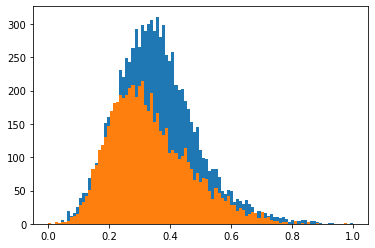

In [36]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3568611 0.33379674
0.13165957 0.13173275


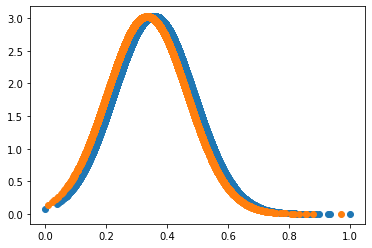

In [37]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

### 3-3 result visualize

In [38]:
detect_error_0 = []
detect_error_1 = []

for i in range(0, 15000):
    if int(bol_test_labels[i]) != gt_labels[i]:
        if gt_labels[i] == 0:
            detect_error_0.append(i)
        else:
            detect_error_1.append(i)

In [43]:
print(len(detect_error_0))
print(len(detect_error_1))

3370
3370


In [39]:
print('accuracy :', 1-(15000-len(detect_error_0)-len(detect_error_1))/15000)

accuracy : 0.44933333333333336


각각 0을 1로 판별하거나 1을 0으로 판별한 데이터들을 추려보았다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

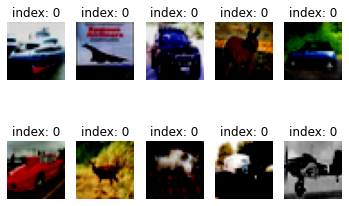

In [40]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_data[detect_error_0[i]], cmap='gray')
    plt.title(f'index: 0')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

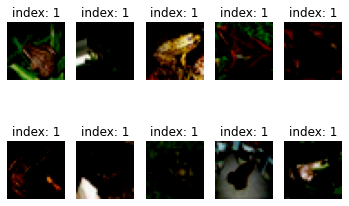

In [41]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_data[detect_error_1[i]], cmap='gray')
    plt.title(f'index: 1')
    plt.axis('off')
plt.show()

## 총평

5 epoch 시 정확도는 43%정도였으나 25 epoch시 정확도는 45%에 불과했다.
GAN 모델 자체의 성능 부족으로 발생한 문제로 파악된다.
